<a href="https://colab.research.google.com/github/theolouvet/DatasetTest/blob/master/leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from zipfile import ZipFile
import io
import cv2 
from google.colab import files
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
#from sklearn.datasets import fetch_mldata
#from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn import svm  
from sklearn import datasets  , metrics
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from PIL import Image
from io import BytesIO
from sklearn.model_selection import validation_curve

Ouverture de l'archive contenant les datas et le csv

In [ ]:
#file_name = "Output_seuillage.zip"
file_name = "New_seuillage_5_species.zip"
#file_name = "Seuillage_full_species.zip"
#path_csv = '/content/Output_seuillage/small_training_dataset.csv'

path_csv = '/content/Seuillage/train_dataset_5_species_new_seuillage.csv'
with ZipFile(file_name, 'r') as zip:
  zip.extractall();
  print('done')
csv = pd.read_csv(path_csv)
csv.columns = [c.replace(' ', '_') for c in csv.columns]


done


In [ ]:
categories = {}
for row in csv.species.values:
      if row not in categories:
        categories[row] = 0
nb_categories = len(categories)
values = np.linspace(0.0, 1.0, num= nb_categories)

print(len(values))
print(nb_categories) 
i = 0
for v in categories:
  categories[v] = i
  i = i+1
print(categories)

5
5
{'Aesculus hippocastanum': 0, 'Populus nigra': 1, 'Viburnum tinus': 2, 'Corylus avellana': 3, 'Syringa vulgaris': 4}


Construction de X (data) et Y (Target)

In [ ]:
#folder = '/content/Output_seuillage/'
folder = "/content/Seuillage/"
formatimage = ".jpg"



test_file = folder + str(csv.loc[0,'ID']) + formatimage
shap = csv.shape;
Nb_data = shap[0];
Nb_data_train = 500 
Nb_data_test = Nb_data 
print(Nb_data)
print(Nb_data_test)
X = []
Y = []
s0 = 0
for raw in range(0,Nb_data):
  imfile = r'{}'.format(folder +str(csv.loc[raw,'ID']) + formatimage)
  #imfile = folder + r'10152.jpg'
  im = cv2.imread(imfile, 0)
  

  im = im/ 255.
  n = size(im)
  if s0<n:
    s0 = n
print(s0)
#cv2.imread(r'/content/Output_seuillage/21288.jpg')
for raw in range(0,Nb_data):
  imfile = folder + str(csv.loc[raw,'ID'])+formatimage
  
  im = cv2.imread(imfile, 0)
  im = im/ 255.
 
  #im = cv2.resize(im, (784,1))
  arr = np.array(im)
  flat = arr.ravel()
  vector = np.matrix(flat)
  if size(flat) < s0:
    A = np.zeros(s0 - size(flat))
    flat = np.append(flat, A.ravel())
  if s0 < size(flat):
    flat = flat[:s0]
  X.append(flat)

  
  specie = str(csv.loc[raw,'species'])
  '''
  if specie == "Syringa vulgaris":
    Y.append(int(1))
  else:
    Y.append(int(0))
  '''
  Y.append(categories[specie]) 
     

675
675
1000


Utilisation d'un modèle et construction de la courbe de validation 

[0, 1, 2, 3, 1, 3, 0, 2, 1, 2]
500
175
test 

Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.89      0.98      0.93        55
           2       0.87      0.91      0.89        43
           3       0.86      0.82      0.84        39
           4       0.81      0.81      0.81        26

    accuracy                           0.87       175
   macro avg       0.88      0.80      0.83       175
weighted avg       0.87      0.87      0.86       175


Confusion matrix:
[[ 6  2  2  1  1]
 [ 0 54  0  0  1]
 [ 0  0 39  4  0]
 [ 0  2  2 32  3]
 [ 0  3  2  0 21]]


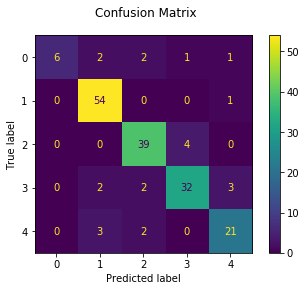

In [ ]:
print(Y[:10])
x_train = X[:Nb_data_train]
y_train = Y[:Nb_data_train]
print(len(x_train))
x_test = X[Nb_data_train:Nb_data_test]
y_test = Y[Nb_data_train:Nb_data_test]
print(len(x_test))
svc = svm.SVC(kernel = 'rbf', C = 1).fit(x_train, y_train)

predicted = svc.predict(x_test)
print("test " + "\n")
print("Classification report for classifier %s:\n%s\n"
    % (svc, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(svc, x_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()
param_range = np.logspace(-6,-1,5)
train_scores, test_scores = validation_curve(svm.SVC(), x_train, y_train, param_name="gamma", param_range=param_range, cv=5, scoring="accuracy", n_jobs=1)


Affichage de la courbe de validation

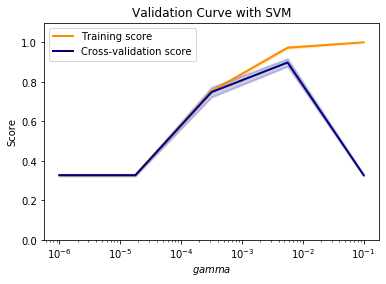

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:

print(svc.predict(x_test))
print('onznpofjhzapohfpozah')
print(y_test - svc.predict(x_test))

[3 3 1 4 2 4 2 2 3 3 4 1 3 1 3 3 3 2 2 1 2 1 3 1 2 0 2 1 1 1 3 1 4 1 1 4 4
 3 2 2 3 1 3 3 1 4 1 3 0 2 4 4 3 2 1 1 3 3 3 2 1 3 1 4 1 4 3 2 3 3 3 2 2 1
 1 4 1 3 0 2 2 1 3 2 4 1 2 3 1 4 2 1 1 3 1 1 1 1 3 4 2 2 2 2 3 2 1 1 1 2 1
 4 2 3 1 0 1 4 1 2 1 1 1 4 4 2 1 1 1 4 0 2 4 2 1 2 4 2 1 1 1 3 4 2 1 1 4 3
 1 2 1 2 1 1 4 2 3 1 2 1 2 2 2 4 3 0 1 3 1 3 2 1 2 1 2]
onznpofjhzapohfpozah
[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 -1  0
  1  0  0  0  0  0 -1  2 -1  0  0 -1  0  0  0  0 -3  0  0  0  0 -4  3  0
  0  2  0  0  0  0  0  0  0  0  0  1  3 -1  0  0  0 -1  0 -2  0  0  0  0
  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0 -2  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -3  0  3  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]


In [ ]:
svc = svm.SVC().fit(x_train, y_train)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma': np.logspace(-6,-1,5)}

validator = GridSearchCV(svc,
                         parameters, cv = 5)
validator.fit(x_train, y_train)
print('The parameters of the best model are: ')
print(validator.best_params_)




param_range = np.logspace(-6,-1,5)
train_scores, test_scores = validation_curve(svc, x_train, y_train, param_name="gamma", param_range=param_range, cv=5, scoring="accuracy", n_jobs=1)

The parameters of the best model are: 
{'C': 10, 'gamma': 0.005623413251903491, 'kernel': 'rbf'}


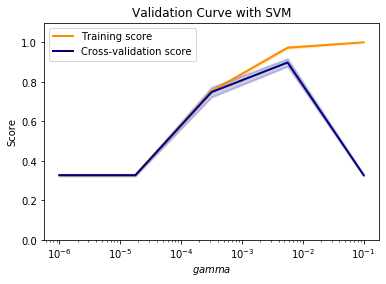

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
print(svc.predict(x_test))
print('Resultat')
print(y_test - svc.predict(x_test))
#33446


[3 3 1 4 2 4 2 2 3 3 4 1 3 1 3 3 3 2 2 1 2 1 3 1 2 0 2 1 1 1 3 1 4 1 1 4 4
 3 2 2 3 1 3 3 1 4 1 3 0 2 4 4 3 2 1 1 3 3 3 2 1 3 1 4 1 4 3 2 3 3 3 2 2 1
 1 4 1 3 0 2 2 1 3 2 4 1 2 3 1 4 2 1 1 3 1 1 1 1 3 4 2 2 2 2 3 2 1 1 1 2 1
 4 2 3 1 0 1 4 1 2 1 1 1 4 4 2 1 1 1 4 0 2 4 2 1 2 4 2 1 1 1 3 4 2 1 1 4 3
 1 2 1 2 1 1 4 2 3 1 2 1 2 2 2 4 3 0 1 3 1 3 2 1 2 1 2]
Resultat
[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 -1  0
  1  0  0  0  0  0 -1  2 -1  0  0 -1  0  0  0  0 -3  0  0  0  0 -4  3  0
  0  2  0  0  0  0  0  0  0  0  0  1  3 -1  0  0  0 -1  0 -2  0  0  0  0
  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0 -2  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -3  0  3  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]


In [ ]:
imfile = folder + '33526'+formatimage
print(imfile)
im = cv2.imread(imfile, 0)
Xf = []
im = im/ 255.
arr = np.array(im)
flat = arr.ravel()
vector = np.matrix(flat)
if size(flat) < s0:
  A = np.zeros(s0 - size(flat))
  flat = np.append(flat, A.ravel())
if s0 < size(flat):
  flat = flat[:s0]
Xf.append(flat)
print(svc.predict(Xf))

/content/Seuillage/33526.jpg
[3]
